In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import re
import os
import zlib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sys
import seaborn as sns
from sklearn.cluster import KMeans
import nltk
nltk.downloader.download('vader_lexicon')
from langdetect import detect

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thomasdorveaux/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
Spotify = pd.read_csv('SpotifyFeatures.csv')
lyrics = pd.read_csv('only_lyrics.csv')

## Merging lyrics and the songs

In [28]:
Spotify['track_name']=Spotify['track_name'].str.lower()
Spotify['track_name']=Spotify['track_name'].str.strip()
Spotify['artist_name']=Spotify['artist_name'].str.lower()
Spotify['artist_name']=Spotify['artist_name'].str.strip()
lyrics['song']=lyrics['song'].str.lower()
lyrics['song']=lyrics['song'].str.strip()
lyrics['artist']=lyrics['artist'].str.lower()
lyrics['artist']=lyrics['artist'].str.strip()

In [29]:
song_lyrics = Spotify.merge(lyrics, left_on=['track_name', 'artist_name'], right_on=['song', 'artist'])  

In [30]:
song_lyrics =song_lyrics.sort_values(by=['popularity'],ascending=False)
song_lyrics = song_lyrics.reset_index()


In [31]:
song_lyrics=song_lyrics.drop(['index','artist', 'song', 'link'], axis=1)

In [32]:
#clean_lyrics(song_lyrics.iloc[675,-1])

## Pre-processing lyrics

In [33]:
def clean_lyrics(lyrics):
    new_lyrics = re.sub(r'[\(\[].*?[\)\]]', ' ', lyrics)
    new_lyrics = new_lyrics.replace("\n", " ")
    #new_lyrics = new_lyrics.replace(""\"","")
    new_lyrics= new_lyrics.strip()
    new_lyrics= new_lyrics.replace("    ", " ")
    new_lyrics= new_lyrics.replace("   ", " ")
    new_lyrics= new_lyrics.replace("  ", " ")
    new_lyrics = os.linesep.join([s for s in new_lyrics.splitlines() if s])
    return(new_lyrics)

In [34]:
def get_compression_rate(lyrics):
    original = lyrics.encode('utf-8')
    compressed = zlib.compress(original)
    decompressed = zlib.decompress(compressed)
    
    compression_rate = (len(original)-len(compressed))/len(original)
    return compression_rate

In [35]:
#Apply clean_lyrics function to text column
song_lyrics['text'] = song_lyrics['text'].map(clean_lyrics)

#Append new column with compression rate
song_lyrics['compression_rate'] = song_lyrics['text'].map(get_compression_rate)

In [44]:
#Drop duplicates
song_lyrics = song_lyrics.sort_values(by='popularity', ascending=False)
song_lyrics = song_lyrics.drop_duplicates(subset='track_id', keep="first")

#Keep only english songs
song_lyrics['language'] = song_lyrics['text'].map(detect)
song_lyrics = song_lyrics[song_lyrics['language'] =="en"]

KeyboardInterrupt: 

### Addition of sentment analysis (+,-,=) values

In [13]:
sia=SentimentIntensityAnalyzer()
sentiment = pd.DataFrame(columns=('id','senti_positive', 'senti_neutral', 'senti_negative'))
for i in range(len(song_lyrics['text'])):
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    lyric= song_lyrics.iloc[i,-2]
    for j in lyric.split():
        comp = sia.polarity_scores(j)
        comp = comp['compound']
        #print(test)
        if comp >= 0.5:
            num_positive += 1
            #print('positive:',i)
        elif comp > -0.5 and comp < 0.5:
            num_neutral += 1
        else:
            num_negative += 1
        #print('negative:',i)
    sentiment.loc[i] = (song_lyrics.iloc[i,3],num_positive,num_neutral,num_negative)
#num_total = num_negative + num_neutral + num_positive
#print('Total score:',num_total)
#print('Negative score:',num_negative)
#print('Neutral score:',num_neutral)
#print('Positive score:',num_positive)
sentiment.head()

,id,senti_positive,senti_neutral,senti_negative
0,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5
1,2374M0fQpWi3dLnB54qaLX,0,268,0
2,1EzrEOXmMH3G43AXT1y7pA,13,295,0
3,34gCuhDGsG4bRPIf9bb02f,16,310,0
4,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1


In [14]:
sentiment.shape

(5274, 4)

In [15]:
song_lyrics = song_lyrics.merge(sentiment, left_on=['track_id'], right_on=['id'])
song_lyrics.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,speechiness,tempo,time_signature,valence,text,compression_rate,id,senti_positive,senti_neutral,senti_negative
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,...,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,1HNkqx9Ahdgi1Ixy2xkKkL,6,310,5
1,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,0.000080,...,0.0323,92.717,4/4,0.732,I hear the drums echoing tonight But she hears...,0.637233,2374M0fQpWi3dLnB54qaLX,0,268,0
2,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,0.000000,...,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I ...,0.572757,1EzrEOXmMH3G43AXT1y7pA,13,295,0
3,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474,0.781,281560,0.445,0.000000,...,0.0295,78.998,4/4,0.591,When your legs don't work like they used to be...,0.623063,34gCuhDGsG4bRPIf9bb02f,16,310,0
4,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,0.000064,...,0.0414,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night s...",0.640961,5Nm9ERjJZ5oyfXZTECKmRt,10,152,1


In [16]:
song_lyrics=song_lyrics.drop(['id'], axis=1)

In [17]:
song_lyrics.shape

(5274, 23)

In [18]:
song_lyrics['senti_total']=song_lyrics['senti_positive']-song_lyrics['senti_negative']

In [19]:
song_lyrics.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,speechiness,tempo,time_signature,valence,text,compression_rate,senti_positive,senti_neutral,senti_negative,senti_total
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607,0.614,258987,0.379,0.000464,...,0.0476,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,6,310,5,1
1,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257,0.671,295893,0.373,0.000080,...,0.0323,92.717,4/4,0.732,I hear the drums echoing tonight But she hears...,0.637233,0,268,0,0
2,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595,0.686,242187,0.457,0.000000,...,0.0468,150.953,4/4,0.718,Well you done done me and you bet I felt it I ...,0.572757,13,295,0,13
3,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474,0.781,281560,0.445,0.000000,...,0.0295,78.998,4/4,0.591,When your legs don't work like they used to be...,0.623063,16,310,0,16
4,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588,0.418,172724,0.420,0.000064,...,0.0414,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night s...",0.640961,10,152,1,9


## Addition of classes

1. Popularity

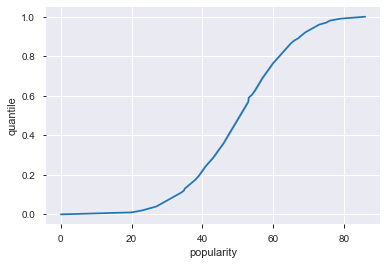

In [20]:
quantile=song_lyrics['popularity'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile=quantile.reset_index()
quantile.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile['popularity'],quantile['quantile'])

In [21]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(quantile)
quantile['cluster']=kmeans.predict(quantile)

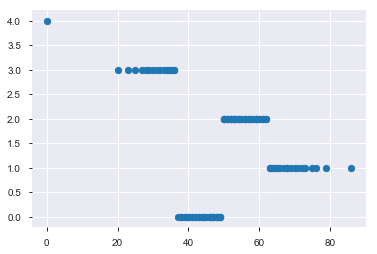

In [22]:
plt.scatter(quantile['popularity'],quantile['cluster'])

In [23]:
one=quantile[quantile.cluster==1]
two=quantile[quantile.cluster==2]
three=quantile[quantile.cluster==3]
zero=quantile[quantile.cluster==0]
four=quantile[quantile.cluster==4]
min_one=np.min(one['popularity'])
max_one=np.max(one['popularity'])
min_two=np.min(two['popularity'])
max_two=np.max(two['popularity'])
min_three=np.min(three['popularity'])
max_three=np.max(three['popularity'])
min_zero=np.min(zero['popularity'])
max_zero=np.max(zero['popularity'])
min_four=np.min(four['popularity'])
max_four=np.max(four['popularity'])
print(1,min_one,max_one)
print(2,min_two,max_two)
print(3,min_three,max_three)
print(4,min_four,max_four)
print(0,min_zero,max_zero)

1 63.0 86.0
2 50.0 62.0
3 20.0 36.0
4 0.0 0.0
0 37.0 49.0


In [24]:
conditions = [
    (song_lyrics['popularity'] >= 78)&(song_lyrics['popularity'] <=100),
    (song_lyrics['popularity'] >= 55)&(song_lyrics['popularity'] <=77),
    (song_lyrics['popularity'] >= 39)&(song_lyrics['popularity'] <=54),
    (song_lyrics['popularity'] >= 19)&(song_lyrics['popularity'] <=38),
    (song_lyrics['popularity'] >= 18)&(song_lyrics['popularity'] <=0)]
choices = [4, 3, 2,1,0]
song_lyrics['label'] = np.select(conditions, choices)
song_lyrics.tail(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,tempo,time_signature,valence,text,compression_rate,senti_positive,senti_neutral,senti_negative,senti_total,label
5273,Country,kris kristofferson,why me,5xpd9uCrrCnh7ssgoAnAFK,0,0.861,0.626,177840,0.255,0.0,...,91.624,3/4,0.492,Why me Lord what have I ever done to deserve e...,0.504505,1,118,0,1,0


In [25]:
song_lyrics

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,...,tempo,time_signature,valence,text,compression_rate,senti_positive,senti_neutral,senti_negative,senti_total,label
0,Pop,ed sheeran,photograph,1HNkqx9Ahdgi1Ixy2xkKkL,86,0.607000,0.614,258987,0.379,0.000464,...,107.989,4/4,0.201,"Loving can hurt, loving can hurt sometimes. Bu...",0.643378,6,310,5,1,4
1,Rock,toto,africa,2374M0fQpWi3dLnB54qaLX,85,0.257000,0.671,295893,0.373,0.000080,...,92.717,4/4,0.732,I hear the drums echoing tonight But she hears...,0.637233,0,268,0,0,4
2,Pop,jason mraz,i'm yours,1EzrEOXmMH3G43AXT1y7pA,85,0.595000,0.686,242187,0.457,0.000000,...,150.953,4/4,0.718,Well you done done me and you bet I felt it I ...,0.572757,13,295,0,13,4
3,Pop,ed sheeran,thinking out loud,34gCuhDGsG4bRPIf9bb02f,85,0.474000,0.781,281560,0.445,0.000000,...,78.998,4/4,0.591,When your legs don't work like they used to be...,0.623063,16,310,0,16,4
4,Pop,sam smith,stay with me,5Nm9ERjJZ5oyfXZTECKmRt,85,0.588000,0.418,172724,0.420,0.000064,...,84.094,4/4,0.184,"Guess it's true, I'm not good at a one-night s...",0.640961,10,152,1,9,4
5,Children’s Music,linkin park,in the end,60a0Rd6pjrkxjPbaKzXjfq,84,0.010300,0.542,216933,0.853,0.000000,...,105.256,4/4,0.370,It starts with one thing I don't know why It d...,0.650965,2,376,1,1,4
6,Dance,ariana grande,one last time,7xoUc6faLbCqZO6fQEYprd,84,0.093000,0.628,197267,0.593,0.000002,...,125.026,4/4,0.104,"I was a liar, I gave into the fire I know I sh...",0.736064,2,387,4,-2,4
7,Rock,twenty one pilots,ride,2Z8WuEywRWYTKe1NybPQEW,83,0.008350,0.645,214507,0.713,0.000000,...,74.989,4/4,0.566,I just wanna stay in the sun where I find I kn...,0.694444,4,333,3,1,4
8,Pop,train,"hey, soul sister",4HlFJV71xXKIGcU3kRyttv,83,0.185000,0.673,216773,0.886,0.000000,...,97.012,4/4,0.795,"Hey, hey, hey Your lipstick stains on the fron...",0.508929,2,225,0,2,4
9,Pop,justin bieber,love yourself,50kpGaPAhYJ3sGmk6vplg0,83,0.856000,0.607,233720,0.376,0.000000,...,102.541,4/4,0.545,For all the times that you rain on my parade A...,0.726236,9,432,1,8,4


2. Acousticness

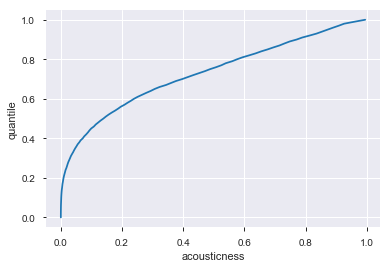

In [26]:
quantile_acou=song_lyrics['acousticness'].quantile(np.arange(0, 1.01, 0.01).tolist())
quantile_acou=quantile_acou.reset_index()
quantile_acou.rename(columns={'index':'quantile'}, inplace=True)
sns.lineplot(quantile_acou['acousticness'],quantile_acou['quantile'])

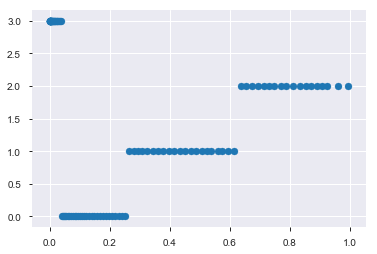

In [27]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(quantile_acou)
quantile_acou['cluster']=kmeans.predict(quantile_acou)
plt.scatter(quantile_acou['acousticness'],quantile_acou['cluster'])

In [28]:
zero=quantile_acou[quantile_acou.cluster==0]
one=quantile_acou[quantile_acou.cluster==1]
two=quantile_acou[quantile_acou.cluster==2]
three=quantile_acou[quantile_acou.cluster==3]
four=quantile_acou[quantile_acou.cluster==4]

min_zero=np.min(zero['acousticness'])
max_zero=np.max(zero['acousticness'])
min_one=np.min(one['acousticness'])
max_one=np.max(one['acousticness'])
min_two=np.min(two['acousticness'])
max_two=np.max(two['acousticness'])
min_three=np.min(three['acousticness'])
max_three=np.max(three['acousticness'])

print(0,min_zero,max_zero)
print(1,min_one,max_one)
print(2,min_two,max_two)
print(3,min_three,max_three)

0 0.04010900000000001 0.251
1 0.265 0.6158599999999996
2 0.637 0.995
3 1.39e-06 0.0363


In [45]:
conditions_acou = [
    (song_lyrics['acousticness'] >= 0.6158599999999996)&(song_lyrics['acousticness'] <=0.995),
    (song_lyrics['acousticness'] >= 0.251)& (song_lyrics['acousticness'] <=0.594),
    (song_lyrics['acousticness'] >= 0.0363)&(song_lyrics['acousticness'] <=0.239),
    (song_lyrics['acousticness'] >= 1.39e-06)&(song_lyrics['acousticness'] <=0.03276299999999999)]
choices_acou = [3, 2,1,0]
song_lyrics['label_acou'] = np.select(conditions_acou, choices_acou)

# Features Engineering

1. Analysing features distributions

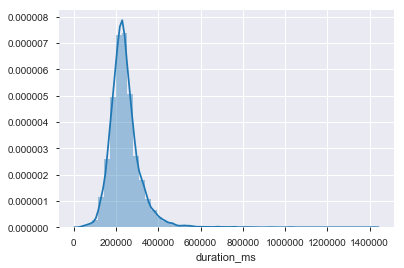

In [33]:
sns.distplot(song_lyrics['duration_ms'])

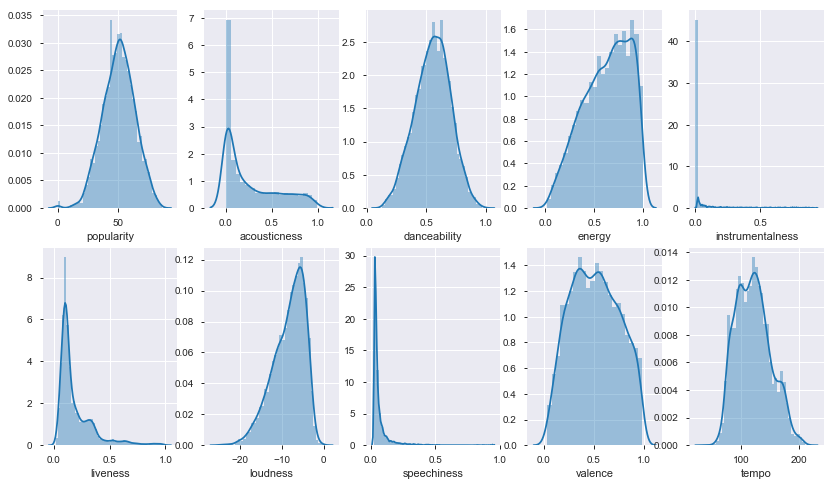

In [34]:
f, axes = plt.subplots(2, 5, figsize=(14, 8), sharex=False)
sns.distplot(song_lyrics['popularity'],ax=axes[0,0])
sns.distplot(song_lyrics['acousticness'],ax=axes[0,1])
sns.distplot(song_lyrics['danceability'],ax=axes[0,2])
sns.distplot(song_lyrics['energy'],ax=axes[0,3])
sns.distplot(song_lyrics['instrumentalness'],ax=axes[0, 4])
sns.distplot(song_lyrics['liveness'],ax=axes[1,0])
sns.distplot(song_lyrics['loudness'],ax=axes[1,1])
sns.distplot(song_lyrics['speechiness'],ax=axes[1,2])
sns.distplot(song_lyrics['valence'],ax=axes[1,3])
sns.distplot(song_lyrics['tempo'],ax=axes[1,4])

(array([ 13.,   1.,   6.,  21.,  28.,  93., 217., 254., 366., 457., 668.,
        645., 640., 689., 427., 301., 250., 122.,  54.,  22.]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ,
        47.3, 51.6, 55.9, 60.2, 64.5, 68.8, 73.1, 77.4, 81.7, 86. ]),
 <a list of 20 Patch objects>)

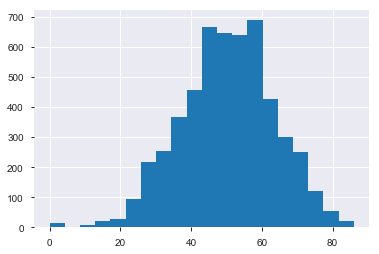

In [35]:
plt.hist(song_lyrics['popularity'], bins=20)

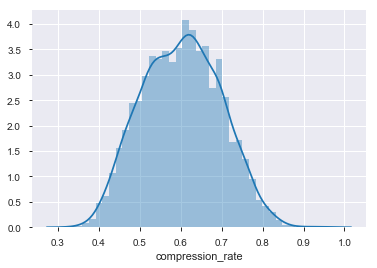

In [36]:
sns.distplot(song_lyrics['compression_rate'])

In [38]:
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_positive'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_neutral'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['senti_total'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['speechiness'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['valence'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['compression_rate'] )
#plt.scatter(song_lyrics['popularity'],song_lyrics['acousticness'] )

2. Encoding

In [41]:
# renaming data before classification

# track features
genre = song_lyrics['genre']
artist_name = song_lyrics['artist_name']
track_name = song_lyrics['track_name']
track_id = song_lyrics['track_id']

# spotify features
popularity = song_lyrics['popularity']
acousticness = song_lyrics['acousticness']
class_acou = song_lyrics['label_acou']
danceability = song_lyrics['danceability']
duration_ms = song_lyrics['duration_ms']
energy = song_lyrics ['energy']
instrumentalness = song_lyrics['instrumentalness']
key = song_lyrics['key']
liveness = song_lyrics['liveness']
loudness = song_lyrics['loudness']
mode = song_lyrics['mode']
speechiness = song_lyrics['speechiness']
tempo = song_lyrics['tempo']
time_signature = song_lyrics['time_signature']
valence = song_lyrics['valence']

# sentimental features
text = song_lyrics['text']
compression_rate = song_lyrics['compression_rate']
senti_positive = song_lyrics['senti_positive']
senti_neutral = song_lyrics['senti_neutral']
senti_negative = song_lyrics['senti_negative']
senti_total = song_lyrics['senti_total']

In [42]:
# encoding discrete data

# track features
genre_encoded = pd.get_dummies(genre,prefix='genre', dummy_na=False)
artist_name_encoded = pd.get_dummies(genre,prefix='artist_name', dummy_na=False)

# spotify features 
key_encoded = pd.get_dummies(key,prefix='key', dummy_na=False)
mode_encoded = pd.get_dummies(mode,prefix='mode', dummy_na=False)
time_signature_encoded = pd.get_dummies(time_signature,prefix='time_signature', dummy_na=False)
class_acou_encoded = pd.get_dummies(time_signature,prefix='class_acou', dummy_na=False)

#sentimal features 
senti_positive_enoded = pd.get_dummies(senti_positive,prefix='senti_positive', dummy_na=False)
senti_neutral_encoded = pd.get_dummies(senti_neutral,prefix='senti_neutral', dummy_na=False)
senti_negative_encoded = pd.get_dummies(senti_negative,prefix='senti_negative', dummy_na=False)
senti_total_encoded = pd.get_dummies(senti_total,prefix='senti_total', dummy_na=False)